In [21]:
from datetime import datetime
import pickle
from pprint import pprint

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## 预处理
除去标题行：27740895 rows x 6 columns
- **transit_timestamp**: from *2022/2/1* to *2024/1/13*, 1 hour interval
- **bus_route**: B1 to B100, and more(Q1, Q2, ...)
- **payment_method**
- **fare_class_category**
- **ridership**: 总是一个非0的值!!!
- **transfers**

1. 删除无关特征值，并将相同特征值的行合并
2. 将数据处理为时间-空间为横纵坐标的形式

### 删除无关特征值，并将相同特征值的行合并
pre1_data.csv：
| bus_route | ridership | timestamp  |
| --------- | --------- | ---------- |
| B1        | 20        | 1672506000 |
| B103      | 42        | 1672506000 |
...


In [22]:
CSV_PATH = r'C:\Users\guil\Downloads\MTA_Bus_Hourly_Ridership__Beginning_February_2022_20240121.csv'
df = pd.read_csv(CSV_PATH)
df.drop(['payment_method', 'fare_class_category'], axis=1, inplace=True)
df = df.groupby(['transit_timestamp', 'bus_route'])['ridership'].sum()
df = df.reset_index()
df.rename(columns={'transit_timestamp': 'time_12h'}, inplace=True)
df['timestamp'] = [datetime.strptime(time, '%m/%d/%Y %I:%M:%S %p').timestamp() for time in df['time_12h']]
df.drop(['time_12h'], axis=1, inplace=True)

df.to_csv('pre1_data.csv')

### 将数据处理为时间-空间坐标形式
pre2_data.csv:
|    (timestamp)        | B1   | B103 | B11  | ... |
| ---------- | ---- | ---- | ---- | --- |
| 1643644800 | 9    | 42   | 8    | ... |
| 1643648400 | 3    | 13   | 1    | ... |

In [23]:
timestamp = df['timestamp'].unique()
timestamp_map = {time: idx for idx, time in enumerate(timestamp)}
bus_route = df['bus_route'].unique()
bus_route_map = {route: idx for idx, route in enumerate(bus_route)}

# data = np.zeros(shape=(len(timestamp), len(bus_route)), dtype=np.int32)
data = np.full(shape=(len(timestamp), len(bus_route)), fill_value=0, dtype=np.int32)
for _, row in tqdm(df.iterrows(), total = len(df)):
    time_idx = timestamp_map[row['timestamp']] 
    route_idx = bus_route_map[row['bus_route']]
    data[time_idx][route_idx] = row['ridership']

result_df = pd.DataFrame(data, columns=bus_route, index=timestamp)
result_df.sort_index(inplace=True)

100%|██████████| 4208600/4208600 [04:08<00:00, 16945.28it/s]


有时间上的缺失值，填充为0

In [39]:
time_start = timestamp.min()  # 1705075200.0  2024-01-13 00:00:00
time_end = timestamp.max()    # 1643644800.0  2022-02-01 00:00:00
print(time_start, time_end)
print(datetime.fromtimestamp(time_start), datetime.fromtimestamp(time_end), end='\n\n')

expected_timestamp = np.arange(time_start, time_end + 3600, 3600)
missing_timestamp = np.setdiff1d(expected_timestamp, timestamp)
print(missing_timestamp.shape)
for ts in missing_timestamp:
    print(datetime.fromtimestamp(ts))
    result_df.loc[ts] = 0

result_df.sort_index(inplace=True)
result_df.drop(result_df.index[-1], inplace=True)  # 去除2024-01-13 00:00:00的数据

result_df.to_csv('pre2_data.csv')

1643644800.0 1705075200.0
2022-02-01 00:00:00 2024-01-13 00:00:00

(25,)
2022-03-13 02:00:00
2022-12-31 01:00:00
2022-12-31 02:00:00
2022-12-31 03:00:00
2022-12-31 04:00:00
2022-12-31 05:00:00
2022-12-31 06:00:00
2022-12-31 07:00:00
2022-12-31 08:00:00
2022-12-31 09:00:00
2022-12-31 10:00:00
2022-12-31 11:00:00
2022-12-31 12:00:00
2022-12-31 13:00:00
2022-12-31 14:00:00
2022-12-31 15:00:00
2022-12-31 16:00:00
2022-12-31 17:00:00
2022-12-31 18:00:00
2022-12-31 19:00:00
2022-12-31 20:00:00
2022-12-31 21:00:00
2022-12-31 22:00:00
2022-12-31 23:00:00
2023-03-12 02:00:00


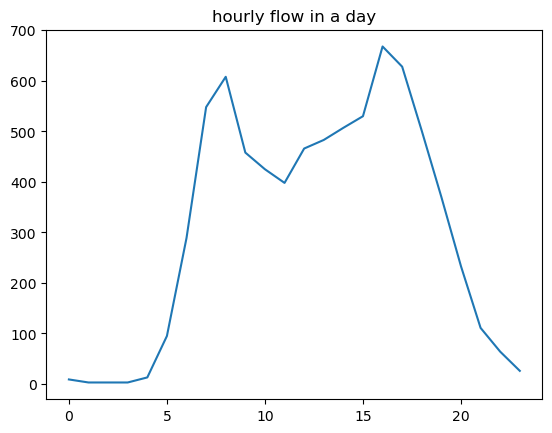

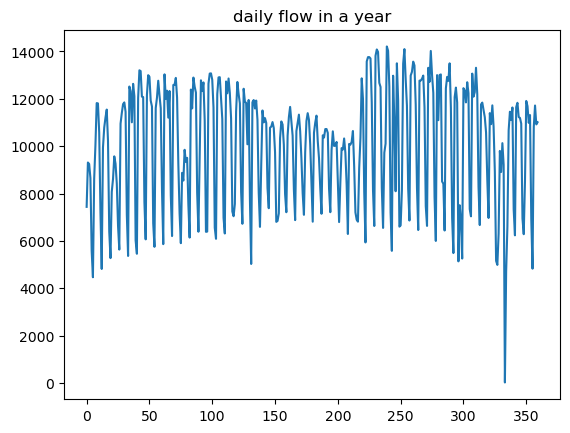

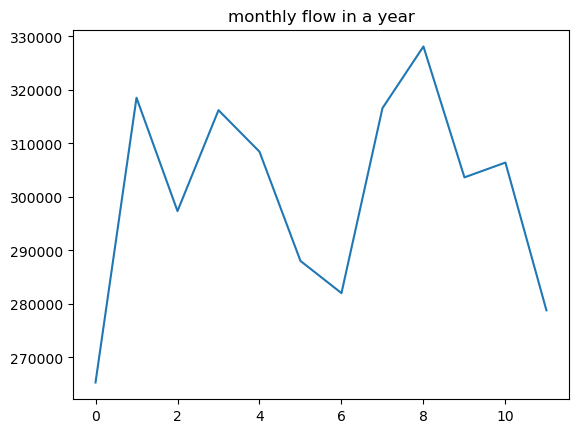

In [25]:
data_hourly = result_df.values[:, 0]
data_daily = data_hourly[:8640].reshape(-1, 24).sum(axis=1)
data_monthly = data_daily[:360].reshape(-1, 30).sum(axis=1)
plt.plot(data_hourly[:24])
plt.title('hourly flow in a day')
plt.show()
plt.plot(data_daily)
plt.title('daily flow in a year')
plt.show()
plt.plot(data_monthly)
plt.title('monthly flow in a year')
plt.show()

## 坐标信息

In [26]:
gdf = gpd.read_file(r'shp\bus_routes_nyc_dec2019.shp').to_crs(epsg=4326)
gdf['centroid'] = gdf['geometry'].centroid
gdf

Exception ignored in: <function tqdm.__del__ at 0x0000013D3469E168>
Traceback (most recent call last):
  File "f:\miniconda3\envs\UCTB\lib\site-packages\tqdm\std.py", line 1149, in __del__
    self.close()
  File "f:\miniconda3\envs\UCTB\lib\site-packages\tqdm\notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
f:\miniconda3\envs\UCTB\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,route_id,route_dir,route_shor,route_long,color,geometry,centroid
0,M101,M101_0,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.94883 40.78586, -73.9483...",POINT (-73.95455 40.79097)
1,M101,M101_1,M101,East Village - Harlem,#FAA61A,"MULTILINESTRING ((-73.93779 40.80386, -73.9379...",POINT (-73.95599 40.79057)
2,M102,M102_0,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.99003 40.72961, -73.9899...",POINT (-73.95775 40.77864)
3,M102,M102_1,M102,Harlem - East Village,#FAA61A,"MULTILINESTRING ((-73.93594 40.82119, -73.9358...",POINT (-73.96047 40.77588)
4,M103,M103_0,M103,East Harlem - City Hall,#B933AD,"MULTILINESTRING ((-73.93533 40.80436, -73.9348...",POINT (-73.96875 40.75806)
...,...,...,...,...,...,...,...
498,Q69,Q69_0,Q69,21 St - Ditmars Blvd,#00AEEF,"LINESTRING (-73.93944 40.74935, -73.93954 40.7...",POINT (-73.92109 40.76566)
499,Q69,Q69_1,Q69,21 St - Ditmars Blvd,#00AEEF,"LINESTRING (-73.88770 40.76522, -73.88808 40.7...",POINT (-73.91907 40.76764)
500,Q70+,Q70+_0,Q70-SBS,LaGuardia Link,#EE352E,"MULTILINESTRING ((-73.90213 40.74576, -73.9021...",POINT (-73.88589 40.76244)
501,Q72,Q72_0,Q72,Junction Blvd - Laguardia Main Term,#B933AD,"MULTILINESTRING ((-73.86284 40.73079, -73.8634...",POINT (-73.87131 40.75581)


同一 route_id 下还会因 route_dir 的不同而有多行数据，取其重心平均值作为最终 route_id 的坐标

In [40]:

df = pd.read_csv('pre2_data.csv')
target_route_id = df.columns
given_route_id = gdf['route_id'].unique()

stationInfoList = []
stationsList = gpd.GeoDataFrame()
for route in tqdm(target_route_id):
    if route not in given_route_id:
        df.drop(columns=[route], inplace=True)
        continue
    stations = gdf[gdf['route_id'] == route]
    # [id, build-time, lat, lng, name]
    stationInfo = [
        route, 
        '2022-2-1', 
        stations['centroid'].y.mean(), 
        stations['centroid'].x.mean(), 
        stations['route_long'].unique()[0]
    ]
    stationInfoList.append(stationInfo)
    stationsList = stationsList.append(stations)

print(df.iloc[:, :5])
pprint(stationInfoList[:2])
print(len(stationInfoList))

100%|██████████| 332/332 [00:01<00:00, 188.23it/s]

        B1  B103  B11  B12  B13
0        9    42    8   33   16
1        3    13    1   12    2
2        3     2    0   12    0
3        3     0    0    7    0
4       13     0   16   46    9
...    ...   ...  ...  ...  ...
17059  435   295  171  191  164
17060  300   198  110  142   83
17061  202   133   78   85   70
17062  125    86   33   40   47
17063   60    48   19   41   15

[17064 rows x 5 columns]
[['B1',
  '2022-2-1',
  40.59505798589783,
  -73.9827295334487,
  'Bay Ridge - Manhattan Beach'],
 ['B103',
  '2022-2-1',
  40.650538013997334,
  -73.9502299527904,
  'Canarsie - Downtown Brooklyn Ltd']]
226


最终只剩下226个 route_id 是有效的，它们在地图上显示如下：

f:\miniconda3\envs\UCTB\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

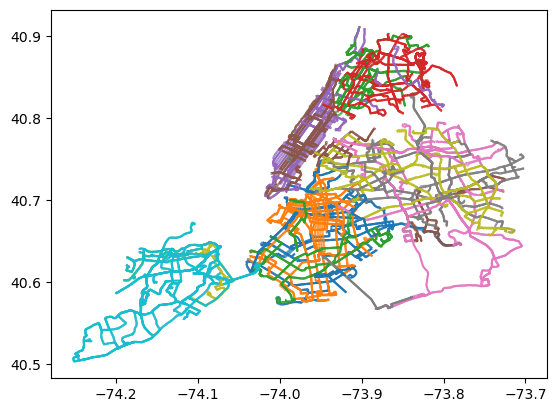

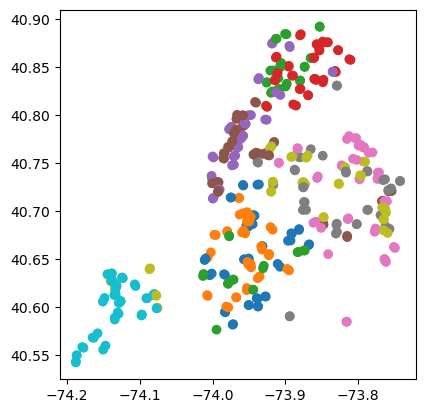

In [28]:
stationsList.plot('route_id')
stationsList.set_geometry('centroid').plot('route_id')

## 保存数据

手动保存

In [29]:
# Save data as CSV
df.to_csv('data_with_station.csv', index=False)
# Save data as pickle
DataFormat = {
    "TimeRange": ['2022-2-1', '2024-1-13'],    # 起止时间 str eg:['2016-10-01', '2016-11-30']
    "TimeFitness": 60,  # 时间粒度 int 单位为min
    "Node": {
        "TrafficNode": df.values,  # np.array, with shape [time_slots, num-of-node] eg:(1440,256) 
        "TrafficMonthlyInteraction": [], # np.array, With shape [month, num-of-node. num-of-node]
        "StationInfo": stationInfoList,  # list of [id, build-time, lat, lng, name], eg:['0', 0, 34.210542575000005, 108.91390095, 'grid_0']
        "POI": []
    },
    "Grid": {
        "TrafficGrid": [], # with shape [slots, num-of-node. num-of-node] eg:(120, 256, 256)
        "GridLatLng": [],  # 对角线点的经纬度 eg:[[34.20829427, 108.91118]]
        "POI": []
    },
    "ExternalFeature": {
        "Weather": []
    }
}

with open('data_with_station.pkl', 'wb') as f:
    pickle.dump(DataFormat, f)

或者使用UCTB提供的API（附带简单的缺失时间验证）

In [43]:
from datetime import timedelta
from dateutil.parser import parse
import os

def print_dic_info(dic, dic_name, tag=''):
    for k in dic:
        print(tag, end='')
        if type(dic[k])==type({}):
            print(f'{dic_name}[{k}]:{type(dic[k])}'+'{')
            print_dic_info(dic[k], f'{dic_name}[{k}]', tag=tag+'\t')
            print('}', end='')
        elif 'numpy' in str(type(dic[k])):
            print(f'{dic_name}[{k}]:{type(dic[k])}  (shape={dic[k].shape})', end='')
        elif type(dic[k])== type([]):
            lis = dic[k]
            s = f'({len(lis)}, {len(lis[0])})' if len(lis)>0 and type(lis[0])==type([]) else f'{len(lis)}'
            print(f'{dic_name}[{k}]:{type(dic[k])}  (len={s})', end='')
        else:
            print(f'{dic_name}[{k}]:{type(dic[k])}', end='')
        print()

def get_timedelta(dic):
    return timedelta(days=0, seconds=0, microseconds=0,milliseconds=0, minutes=dic['TimeFitness'], hours=0, weeks=0)

def build_uctb_dataset(traffic_node, time_fitness, node_station_info, time_range, dataset_name, city,
    traffic_monthly_interaction=None, external_feature_weather=None, node_poi=None, 
    traffic_grid=None, grid_lat_lng=None, gird_poi=None, print_dataset=False, output_dir=None):

    dataset = {'TimeRange':time_range, 'TimeFitness':time_fitness, 'Node':{'TrafficNode':traffic_node, 'StationInfo':node_station_info},
                    'Grid':{}, 'ExternalFeature':{}, 'LenTimeSlots':traffic_node.shape[0]}

    # make sure no data missing in traffic node
    beg_dt = parse(dataset['TimeRange'][0])
    assert beg_dt+(dataset['Node']['TrafficNode'].shape[0])*get_timedelta(dataset) == parse(dataset['TimeRange'][1])

    dataset['Node']['TrafficMonthlyInteraction'] = traffic_monthly_interaction
    dataset['Grid']['TrafficGrid'] = traffic_grid
    dataset['Grid']['GridLatLng'] = grid_lat_lng
    dataset['ExternalFeature']['Weather'] = [] if external_feature_weather is None else external_feature_weather
    
    if node_poi is not None:
        dataset['Node']['POI'] = node_poi
        
    if gird_poi is not None:
        dataset['Grid']['POI'] = gird_poi

    if print_dataset:
        print_dic_info(dataset, 'dataset')

    if output_dir is None:
        pkl_file_name = '{}_{}.pkl'.format(dataset_name, city)
    else:
        pkl_file_name = os.path.join(output_dir, '{}_{}.pkl'.format(dataset_name, city))

    with open(pkl_file_name, 'wb') as f:
        pickle.dump(dataset, f)

build_uctb_dataset(
    time_fitness=60,
    time_range=['2022-2-1', '2024-1-13'],
    traffic_node=df.values,
    node_station_info=stationInfoList,
    dataset_name='BUS',
    city='NYC',
    print_dataset=True,
)

dataset[TimeRange]:<class 'list'>  (len=2)
dataset[TimeFitness]:<class 'int'>
dataset[Node]:<class 'dict'>{
	dataset[Node][TrafficNode]:<class 'numpy.ndarray'>  (shape=(17064, 226))
	dataset[Node][StationInfo]:<class 'list'>  (len=(226, 5))
	dataset[Node][TrafficMonthlyInteraction]:<class 'NoneType'>
}
dataset[Grid]:<class 'dict'>{
	dataset[Grid][TrafficGrid]:<class 'NoneType'>
	dataset[Grid][GridLatLng]:<class 'NoneType'>
}
dataset[ExternalFeature]:<class 'dict'>{
	dataset[ExternalFeature][Weather]:<class 'list'>  (len=0)
}
dataset[LenTimeSlots]:<class 'int'>


## DEBUG
以下代码无需运行

In [33]:
beg_dt = parse('2022-2-1')
end_dt = parse('2024-1-13')
print(beg_dt)
print(end_dt)

2022-02-01 00:00:00
2024-01-13 00:00:00


In [41]:
timedt = timedelta(days=0, seconds=0, microseconds=0,milliseconds=0, minutes=60, hours=0, weeks=0)
beg_dt + df.values.shape[0]*timedt

datetime.datetime(2024, 1, 13, 0, 0)